This notebook is for sanity. In specific to get the absolute and relative failure rate

In [1]:
import polars as pl
from data_io.loader.data_loader import DataLoader
import matplotlib.pyplot as plt
from analysis.visualization.characterisation.helpers import station_outage_rate

dl = DataLoader()


Holidays folder not found: ./data/processed/holidays/


Get the absolute and relative failure rate data of every station

In [2]:
outages = station_outage_rate(dl)
pl.Config.set_tbl_rows(100)
outages

station,start,end,expected_hours,missing_hours,outage_rate
str,i64,i64,i64,i64,f64
"""Ziegelhäuser Landstraße""",2019,2025,59140,24815,0.419598
"""Schlierbacher Landstraße""",2019,2025,59140,23985,0.405563
"""Bahnstadtpromenade""",2020,2025,47150,16800,0.35631
"""Hardtstraße""",2020,2025,50399,10603,0.210381
"""Plöck""",2015,2025,87652,7691,0.087745
"""Kurfürstenanlage Querschnitt""",2019,2025,59140,4981,0.084224
"""Berliner Straße Querschnitt""",2020,2025,50378,4027,0.079936
"""Eppelheimer Str. Querschnitt""",2020,2025,50380,2307,0.045792
"""Liebermannstraße""",2018,2025,61853,1671,0.027016


Plot the failure rate data of the output table above

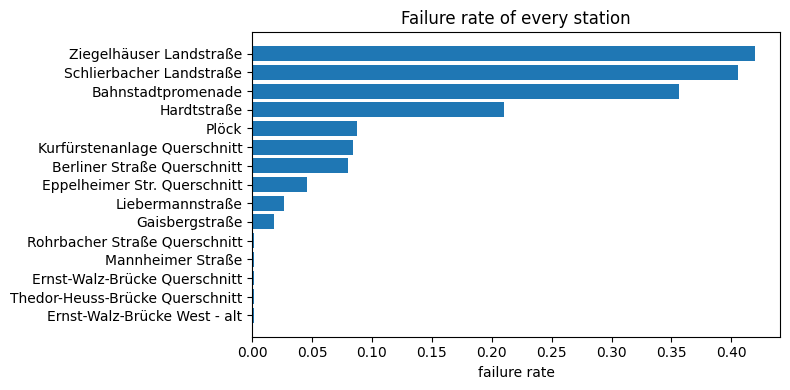

In [3]:


df = outages.sort("outage_rate", descending=True)

plt.figure(figsize=(8, max(4, 0.25 * df.height)))
plt.barh(df["station"], df["outage_rate"])
plt.xlabel("failure rate")
plt.title("Failure rate of every station")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()